<a href="https://colab.research.google.com/github/marcobiazzo/Test-folder/blob/main/Polymarket_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Polimarket Arbitrage Engine

In [3]:
# Installa le librerie necessarie
!pip install requests pandas polymarket-apis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.5/587.5 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 

Sansioniamo i mercati

In [5]:
import requests
import pandas as pd

def get_active_markets():
    # API pubblica per i mercati attivi
    url = "https://gamma-api.polymarket.com/markets?active=true&closed=false&limit=100"
    response = requests.get(url)
    markets = response.json()

    opportunities = []

    for m in markets:
        try:
            # Prendi i prezzi (outcome prices sono stringhe di solito)
            outcomes = m.get('outcomePrices', [])
            if len(outcomes) == 2:
                price_yes = float(outcomes[0])
                price_no = float(outcomes[1])
                total_cost = price_yes + price_no

                if total_cost < 0.98: # Soglia per trovare opportunità (sotto 1$)
                    opportunities.append({
                        'Market': m['question'],
                        'Yes': price_yes,
                        'No': price_no,
                        'Sum': round(total_cost, 3),
                        'Profit %': round((1 - total_cost) * 100, 2)
                    })
        except:
            continue

    return pd.DataFrame(opportunities)

# Esegui la scansione
df = get_active_markets()
if not df.empty:
    df.sort_values(by='Profit %', ascending=False)
else:
    print("No arbitrage opportunities found.")

No arbitrage opportunities found.


Visualizziamo un mercato

In [6]:
!pip install requests pandas matplotlib seaborn plotly

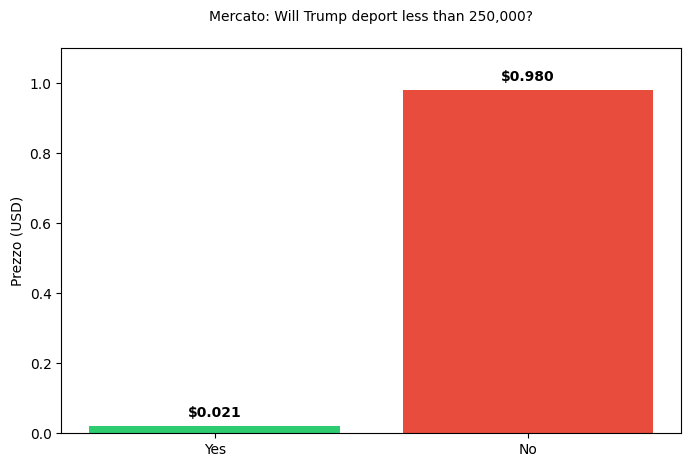

Somma Prezzi: 1.000
Profitto Arbitraggio: 0.00%


In [9]:
import requests
import json
import matplotlib.pyplot as plt

def fetch_and_plot_single_market():
    url = "https://gamma-api.polymarket.com/markets?active=true&closed=false&limit=1"

    try:
        response = requests.get(url)
        data = response.json()

        if not data:
            print("Nessun mercato trovato.")
            return

        market = data[0]
        question = market.get('question', 'Titolo non disponibile')

        # --- FIX ERRORE DI CONVERSIONE ---
        # Recuperiamo i prezzi grezzi
        prices_raw = market.get('outcomePrices')

        # Se i prezzi sono una stringa tipo '["0.5", "0.5"]', li trasformiamo in lista
        if isinstance(prices_raw, str):
            prices_raw = json.loads(prices_raw)

        # Ora convertiamo ogni elemento in float in modo sicuro
        prices = [float(p) for p in prices_raw if p]

        # Stessa cosa per gli outcomes (Yes/No)
        outcomes = market.get('outcomes')
        if isinstance(outcomes, str):
            outcomes = json.loads(outcomes)
        # ---------------------------------

        # Creazione del Grafico
        plt.figure(figsize=(8, 5))
        colors = ['#2ecc71', '#e74c3c'] if len(prices) == 2 else plt.cm.Paired(range(len(prices)))

        bars = plt.bar(outcomes, prices, color=colors)

        plt.ylim(0, 1.1) # Un po' di margine sopra
        plt.ylabel('Prezzo (USD)')
        plt.title(f"Mercato: {question}", fontsize=10, pad=20)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
                     f"${yval:.3f}", ha='center', va='bottom', fontweight='bold')

        plt.show()

        print(f"Somma Prezzi: {sum(prices):.3f}")
        print(f"Profitto Arbitraggio: {max(0, (1 - sum(prices)) * 100):.2f}%")

    except Exception as e:
        print(f"Errore: {e}")

fetch_and_plot_single_market()

Here I am visualising all the markets and poly market. I am trying to identify the arbitrage opportunities and display them in the table.

In [24]:
print(df_final.loc[18, 'Kalshi'])

yes Detroit wins by over 4.5 Points,no Oklahoma City wins by over 10.5 Points,yes Toronto wins by over 2.5 Points,yes Florida wins by over 1.5 Points,no Illinois wins by over 4.5 Points,no Minnesota wins by over 10.5 Points,yes Purdue wins by over 8.5 Points


In [10]:
import requests
import json
import pandas as pd
from google.colab import data_table

def get_arbitrage_table():
    # Aumentiamo il limite a 100 per trovare più opportunità
    url = "https://gamma-api.polymarket.com/markets?active=true&closed=false&limit=100"

    try:
        response = requests.get(url)
        markets = response.json()

        rows = []
        for m in markets:
            # Parsing prezzi
            p_raw = m.get('outcomePrices')
            if isinstance(p_raw, str): p_raw = json.loads(p_raw)

            # Parsing esiti
            o_raw = m.get('outcomes')
            if isinstance(o_raw, str): o_raw = json.loads(o_raw)

            if p_raw and len(p_raw) >= 2:
                try:
                    prices = [float(p) for p in p_raw if p]
                    total_sum = sum(prices)
                    profit = (1 - total_sum) * 100
                    volume = float(m.get('volume', 0))

                    rows.append({
                        'Mercato': m.get('question'),
                        'Prezzi': prices,
                        'Somma': round(total_sum, 3),
                        'Profitto %': round(profit, 2),
                        'Volume USD': int(volume)
                    })
                except:
                    continue

        df = pd.DataFrame(rows)

        # Ordiniamo per profitto decrescente
        df = df.sort_values(by='Profitto %', ascending=False)
        return df

    except Exception as e:
        print(f"Errore: {e}")
        return pd.DataFrame()

# 1. Ottieni i dati
df_opportunities = get_arbitrage_table()

# 2. Abilita la visualizzazione interattiva di Colab
data_table.enable_dataframe_formatter()

# 3. Mostra la tabella (mostriamo solo dove c'è potenziale profitto o quasi)
df_opportunities[df_opportunities['Profitto %'] > -1.0]

,Mercato,Prezzi,Somma,Profitto %,Volume USD
0,"Will Trump deport less than 250,000?","[0.02, 0.98]",1.0,0.0,1020774
1,"Will Trump deport 250,000-500,000 people?","[0.868, 0.132]",1.0,0.0,1187690
2,"Will Trump deport 500,000-750,000- people?","[0.0605, 0.9395]",1.0,0.0,467144
3,"Will Trump deport 750,000-1,000,000 people?","[0.01, 0.99]",1.0,0.0,447386
4,"Will Trump deport 1,000,000-1,250,000 people?","[0.0055, 0.9945]",1.0,0.0,432262
...,...,...,...,...,...
95,Will RJ Harvey be the 2025-2026 NFL Offensive ...,"[0.0005, 0.9995]",1.0,0.0,50698
96,Will TreVeyon Henderson be the 2025-2026 NFL O...,"[0.006, 0.994]",1.0,0.0,108191
97,Will Jalen Milroe be the 2025-2026 NFL Offensi...,"[0.0005, 0.9995]",1.0,0.0,32012
98,Will Colston Loveland be the 2025-2026 NFL Off...,"[0.0005, 0.9995]",1.0,0.0,19762


Here I am comparing kalshi with poly market data an issue here is to identify the same events on the two markets to do this. We tried several strategies one of the strategies that allowed us to find some results was the one using a word batch. The problem is that markets there are matched by algorithms are not the same, it is not the same event.
---



In [23]:
import requests
import json
import pandas as pd
from google.colab import data_table

def get_ultra_flexible_comparison():
    print("🚀 Scaricamento massivo dei mercati in corso...")

    # 1. POLYMARKET - Scarichiamo un set ampio
    poly_data = requests.get("https://gamma-api.polymarket.com/markets?active=true&closed=false&limit=1000").json()

    # 2. KALSHI - Scarichiamo un set ampio
    k_res = requests.get("https://api.elections.kalshi.com/trade-api/v2/markets?status=open&limit=1000").json()
    kalshi_data = k_res.get('markets', [])

    results = []

    # Parole comuni da ignorare (più ampio è questo set, più preciso è il match)
    stop_words = {
        'will', 'above', 'below', 'than', 'index', 'price', 'date', 'level', 'market',
        'the', 'and', 'for', 'any', 'before', 'after', 'point', 'points', 'value'
    }

    print(f"Analisi di {len(poly_data)} mercati Poly vs {len(kalshi_data)} mercati Kalshi...")

    for pm in poly_data:
        p_title = pm.get('question', "").lower()
        # Estraiamo parole chiave di Polymarket (solo lettere e numeri, > 2 caratteri)
        p_words = set(w.strip("?,.!") for w in p_title.split() if len(w) > 2 and w not in stop_words)

        if not p_words: continue

        for km in kalshi_data:
            k_title = km.get('title', "").lower()
            k_words = set(w.strip("?,.!") for w in k_title.split() if len(w) > 2 and w not in stop_words)

            # Calcoliamo l'intersezione
            common = p_words.intersection(k_words)

            # SOGLIA MINIMA: 2 parole chiave identiche
            if len(common) >= 2:
                try:
                    # Prezzi Poly
                    p_raw = pm.get('outcomePrices')
                    if isinstance(p_raw, str): p_raw = json.loads(p_raw)
                    py = float(p_raw[0])
                    pn = float(p_raw[1])

                    # Prezzi Kalshi
                    ky = (km.get('yes_bid', 0) / 100) or (km.get('last_price', 0) / 100)
                    kn = (km.get('no_bid', 0) / 100) or (1 - ky if ky > 0 else 0)

                    if ky == 0 or py == 0: continue

                    # Arbitraggio
                    arb1 = (1 - (py + kn)) * 100
                    arb2 = (1 - (pn + ky)) * 100

                    results.append({
                        'Match': " ".join(list(common)[:3]), # Mostra le prime 3 parole in comune
                        'Polymarket': pm.get('question'),
                        'Kalshi': km.get('title'), # Removed truncation
                        'P-YES': f"${py:.2f}",
                        'K-YES': f"${ky:.2f}",
                        'Profitto Arb %': round(max(arb1, arb2), 2),
                        'Vol Poly': int(float(pm.get('volume', 0))),
                        'Vol Kalshi': int(float(km.get('volume', 0)))
                    })
                except:
                    continue

    df = pd.DataFrame(results)

    if df.empty:
        print("❌ Nessun match trovato nemmeno con matching ultra-flessibile.")
        print("Questo accade se le due piattaforme non coprono gli stessi eventi oggi.")
    else:
        # Rimuoviamo duplicati (stesso match)
        df = df.drop_duplicates(subset=['Polymarket', 'Kalshi'])
        print(f"✅ Trovati {len(df)} potenziali match!")

    return df.sort_values(by='Profitto Arb %', ascending=False)

# Esecuzione
data_table.enable_dataframe_formatter()
df_final = get_ultra_flexible_comparison()
df_final

print("\nL'indice (la colonna più a sinistra senza intestazione) in questa tabella è un identificatore univoco per ogni riga, assegnato automaticamente da Pandas.")


🚀 Scaricamento massivo dei mercati in corso...
Analisi di 500 mercati Poly vs 1000 mercati Kalshi...
✅ Trovati 59 potenziali match!

L'indice (la colonna più a sinistra senza intestazione) in questa tabella è un identificatore univoco per ogni riga, assegnato automaticamente da Pandas.


Let's print only index number 18.

In [27]:
display(df_final.loc[18])

,18
Match,city oklahoma
Polymarket,Will the Oklahoma City Thunder win the 2026 NB...
Kalshi,"yes Detroit wins by over 4.5 Points,no Oklahom..."
P-YES,$0.40
K-YES,$0.15
Profitto Arb %,24.5
Vol Poly,3153201
Vol Kalshi,62


In [26]:
print(df_final.loc[18, 'Polymarket'])

Will the Oklahoma City Thunder win the 2026 NBA Finals?


In [25]:
print(df_final.loc[18, 'Kalshi'])

yes Detroit wins by over 4.5 Points,no Oklahoma City wins by over 10.5 Points,yes Toronto wins by over 2.5 Points,yes Florida wins by over 1.5 Points,no Illinois wins by over 4.5 Points,no Minnesota wins by over 10.5 Points,yes Purdue wins by over 8.5 Points


There is something wrong here. The name of the Kalshi market is not corresponding to the one that I find on the website let's dive deep into the specific market.

We definitely have a problem here with the logic that is matching the markets because I can find on Kashi the market "Pro basketball champion" that bets on the NBA champion and on Polymarket I can find the market "2026 NBA champion". They are basically the same market and there is no arbitrage opportunities, but our logic doesn't work.